Copyright (C) 2025 
Hak Cipta Dilindungi Undang-Undang
Tidak diperbolehkan untuk menyalin, mendistribusikan, atau menggunakan tanpa izin tertulis.

Perangkat Lunak Analisis Kapasitas Konservasi Air berbasis Geospasial dengan Python dan Jupyter Notebook

OLEH
Ir. Irmadi Nahib, M.Si  (Ketua)
Prof. Dr. Ir. Widiatmaka, DAA, IPU (Anggota)
Prof. Dr. Ir. Suria Darma Tarigan, M.Sc (Anggota)
Dr. Ir.  Wiwin Ambarwulan, MSc  (Anggota)
Fadhlullah Ramadhani, S.Kom., M.Sc., Ph.D. (Anggota)

PROGRAM STUDI
ILMU PENGELOLAAN SUMBERDAYA ALAM DAN LINGKUNGAN SEKOLAH PASCASARJANA
INSTITUT PERTANIAN BOGOR BOGOR
2025



Sumber Data:
1. Tutupan Lahan, raster, resolusi 30m
2. Curah Hujan, raster, satuan= mm
3. Water Yield, raster, InVEST
4. Ksat (Saturated Soil Hydraulic Conductivity), raster



In [9]:
# install paket ini terlebih dahulu

#!pip install rasterio numpy matplotlib

Koefisien Tanpa Dimensi dalam Model Hidrologi: Beberapa model hidrologi menggunakan koefisien tanpa dimensi untuk menyesuaikan kecepatan atau laju aliran sesuai dengan nilai yang dikalibrasi atau ditentukan secara eksperimental yang paling sesuai dengan data yang diamati untuk wilayah atau jenis aliran tertentu.

Perhitungan selesai. Output disimpan di: ./input/velocity2020_v2.tif
Saved plot: ./outputpng\Velocity Coefficient.png


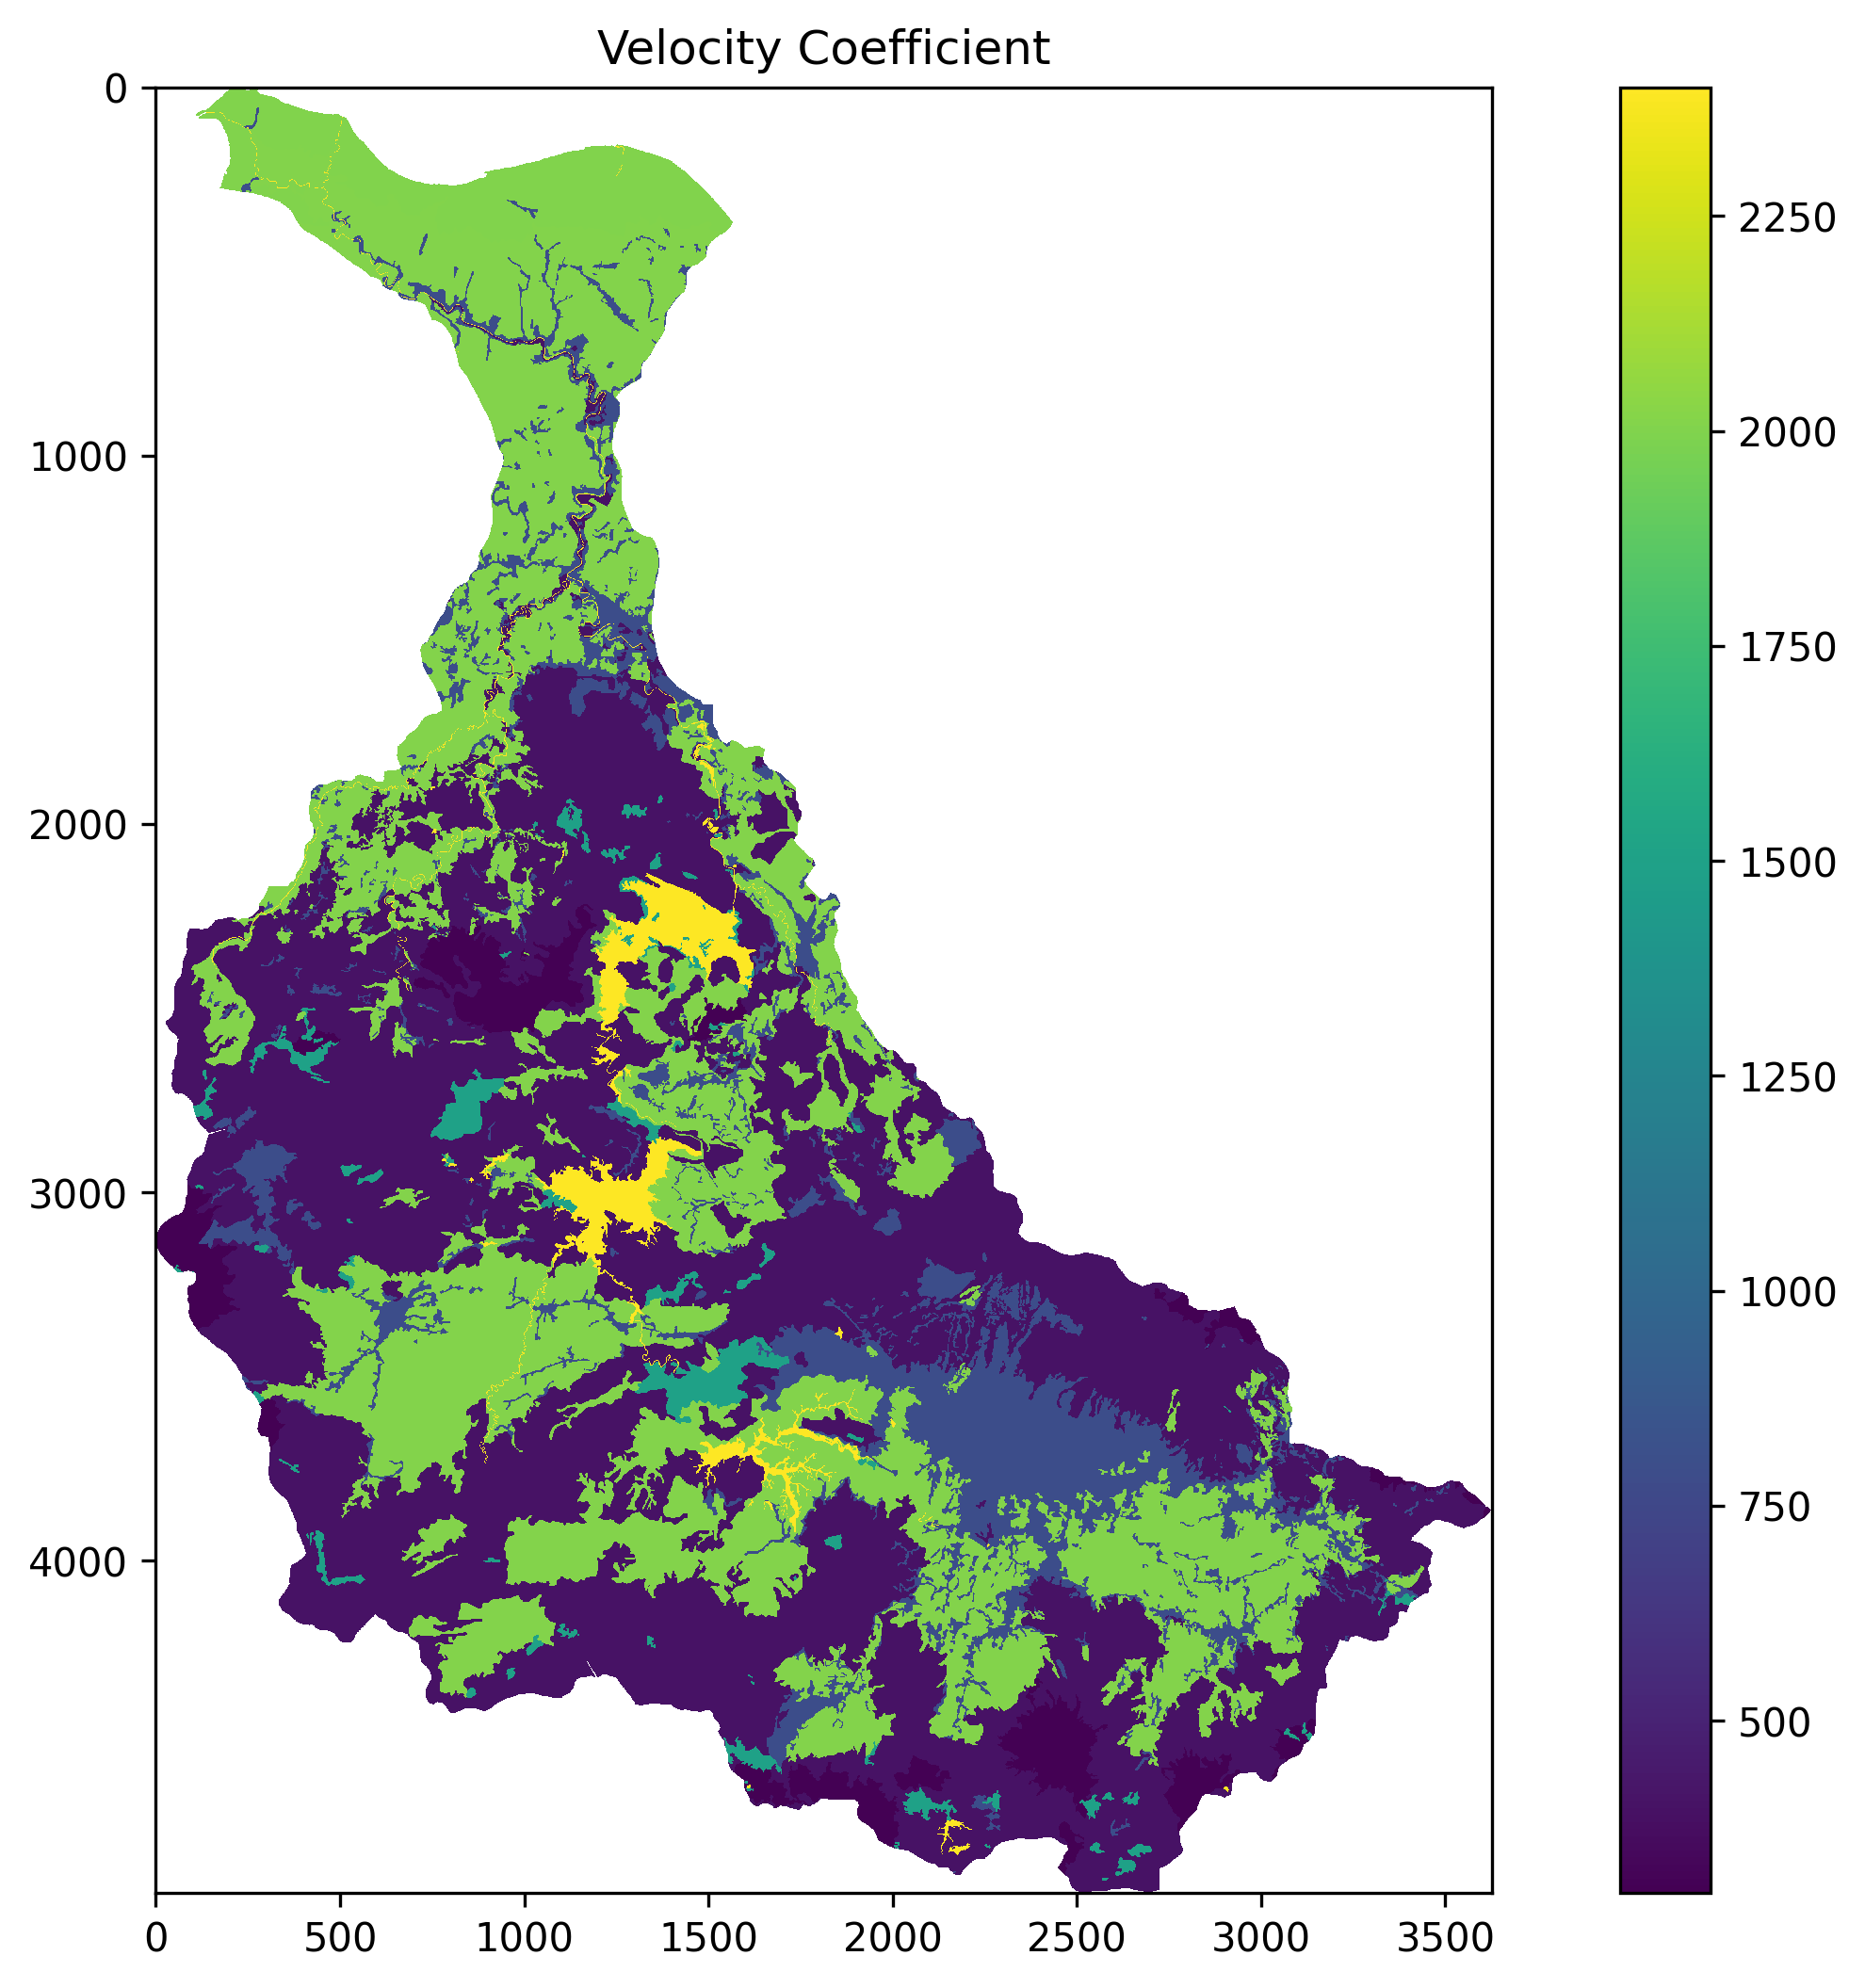

In [10]:
# Hitung koefisien velositas sesuai dengan tutupan lahan yang ada
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def translate_values(input_raster_path, output_raster_path):
    """Translates land cover codes into velocity coefficients and saves the result as a raster."""
    
    # Define the mapping from "Kode" to "Velocity coefficient"
    velocity_coefficients = {
        1: 300,
        2: 400,
        3: 1500,
        4: 400,
        5: 800,
        6: 1500,
        7: 2400,
        8: 400,
        9: 2012,
        10: 2000,
        11: 800
    } 

    # Open the input raster
    with rasterio.open(input_raster_path) as src:
        src_data = src.read(1)
        output_data = np.zeros(src_data.shape, dtype=np.float32)  # Empty array

        # Replace values based on the mapping
        for kode, velocity in velocity_coefficients.items():
            output_data[src_data == kode] = velocity

        # Define metadata for output raster
        output_meta = src.meta.copy()
        output_meta['dtype'] = 'float32'  # Ensure correct datatype

        # Save translated raster
        with rasterio.open(output_raster_path, 'w', **output_meta) as dest:
            dest.write(output_data, 1)

    print(f"Perhitungan selesai. Output disimpan di: {output_raster_path}")
    return output_data, output_meta

def plot_raster(raster_array, raster_name, output_folder):
    """Plots and saves the translated velocity raster."""
    os.makedirs(output_folder, exist_ok=True)

    # Remove 0 values and use NaN for proper visualization
    plot_array = np.where(raster_array == 0, np.nan, raster_array)

    # Compute valid range for color scaling
    vmin, vmax = np.percentile(plot_array[~np.isnan(plot_array)], [2, 98])

    # Create colormap and set NaN (0 values) to white
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    # Plot the raster
    fig, ax = plt.subplots(figsize=(11.7, 8.3), dpi=300)
    im = ax.imshow(plot_array, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(raster_name)
    plt.colorbar(im, ax=ax, fraction=0.05)

    # Save the figure
    output_png_path = os.path.join(output_folder, f"{raster_name}.png")
    plt.savefig(output_png_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot: {output_png_path}")

    # Show the plot
    plt.show()
    plt.close(fig)

# Paths for input raster and output velocity raster
input_raster_path = './input/1_PL_2020_CiTRa.tif'
output_raster_path = './input/velocity2020_v2.tif'
output_png_folder = './outputpng'

# Translate values and plot the output
velocity_raster, velocity_meta = translate_values(input_raster_path, output_raster_path)
plot_raster(velocity_raster, "Velocity Coefficient", output_png_folder)


Kalkulasi Topografi wetness index
dapat dilakukan dengan SAGA GIS:
Modul Indeks Kelembapan SAGA
'Indeks Kelembapan SAGA', seperti namanya, mirip dengan 'Indeks Kelembapan Topografi' (TWI), tetapi didasarkan pada perhitungan daerah tangkapan air yang dimodifikasi ('Modified Catchment Area'), yang tidak menganggap aliran sebagai lapisan yang sangat tipis. Hasilnya, ia memprediksi untuk sel-sel yang terletak di dasar lembah dengan jarak vertikal yang kecil ke saluran, potensi kelembapan tanah yang lebih realistis dan lebih tinggi dibandingkan dengan perhitungan TWI standar.


In [11]:
# 3. Resampling

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Define the input folder containing all raster files
input_folder = '.\input'

# Define the path to the reference raster (Land Use Land Cover, LULC)
lulc_path = os.path.join(input_folder, '1_PL_2020_CiTRa.tif')

# Define the paths to your input raster files within the input folder
raster_paths = {
    'velocity': os.path.join(input_folder, 'velocity2020_v2.tif'),
    'precip': os.path.join(input_folder, 'precip_2020.tif'),
    'ksat': os.path.join(input_folder, 'kst30x30m.tif'),
    'yield': os.path.join(input_folder, 'WY_2020.tif'),
    'TWI': os.path.join(input_folder, 'Topographic Wetness Index2020.tif')
}


# Output folder where the resampled and clipped rasters will be saved
output_folder = 'inputresampling'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

def resample_and_clip_raster(input_raster_path, output_raster_path, reference_transform, reference_crs, reference_width, reference_height):
    with rasterio.open(input_raster_path) as src:
        metadata = src.meta.copy()
        
        # Update metadata to match the reference raster
        metadata.update({
            'driver': 'GTiff',
            'height': reference_height,
            'width': reference_width,
            'transform': reference_transform,
            'crs': reference_crs
        })
        
        with rasterio.open(output_raster_path, 'w', **metadata) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=reference_transform,
                    dst_crs=reference_crs,
                    resampling=Resampling.nearest)

# Get the spatial characteristics of the reference raster
with rasterio.open(lulc_path) as ref:
    reference_transform = ref.transform
    reference_crs = ref.crs
    reference_width = ref.width
    reference_height = ref.height

# Resample and clip each raster based on the reference raster
for name, path in raster_paths.items():
    output_raster_path = os.path.join(output_folder, f"{name}_v3.tif")
    print(f"Resampling and clipping {name} raster...")
    resample_and_clip_raster(path, output_raster_path, reference_transform, reference_crs, reference_width, reference_height)

print("Resampling and clipping completed for all rasters.")


Resampling and clipping velocity raster...
Resampling and clipping precip raster...
Resampling and clipping ksat raster...
Resampling and clipping yield raster...
Resampling and clipping TWI raster...
Resampling and clipping completed for all rasters.


Reading raster: ./inputresampling\velocity_v3.tif
Reading raster: ./inputresampling\TWI_v3.tif
Reading raster: ./inputresampling\ksat_v3.tif
Reading raster: ./inputresampling\yield_v3.tif
Calculating water conservation capacity (konservasi air)...


C:\Users\Dell\AppData\Local\Temp\ipykernel_9516\4181807352.py:33: RuntimeWarning: divide by zero encountered in divide
  np.minimum(1, 249 / velocity_array.data[valid_mask]) *


 - Calculation completed.
Water conservation capacity (konservasi air) calculation complete. Output saved to: ./output\konservasi_air2020_v3.tif
Saved visualization: ./outputpng\konservasi_air_visualization.png


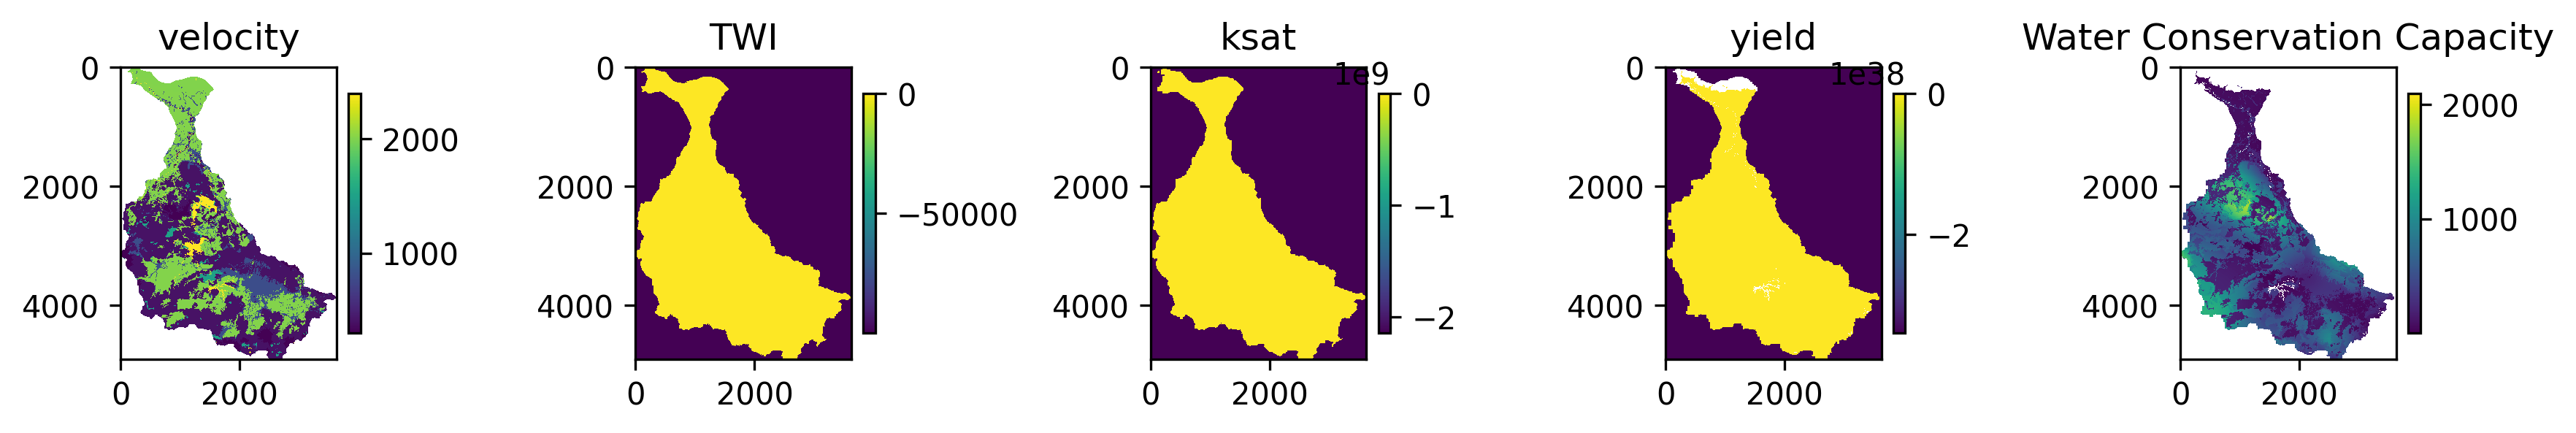

In [12]:
# Kalkulasi Konservasi Air dengan Visualisasi dan Simpan PNG
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

def read_raster_as_array(raster_path):
    """Read a raster file and return its array and metadata."""
    try:
        print(f"Reading raster: {raster_path}")
        with rasterio.open(raster_path) as raster:
            array = raster.read(1, masked=True)  # Use masked array to handle no-data
            meta = raster.meta
            return array, meta
    except Exception as e:
        print(f"Error reading {raster_path}: {e}")
        return None, None

def calculate_konservasi_air(velocity_array, twi_array, ksat_array, yield_array):
    """Calculate water conservation capacity, setting no-data to -99999."""
    print("Calculating water conservation capacity (konservasi air)...")

    if not (velocity_array.shape == twi_array.shape == ksat_array.shape == yield_array.shape):
        print("Error: Raster dimensions do not match!")
        return None
    
    no_data_value = -99999
    valid_mask = (~velocity_array.mask) & (~twi_array.mask) & (~ksat_array.mask) & (~yield_array.mask)

    konservasi_air_array = np.full(velocity_array.shape, no_data_value, dtype=np.float32)
    konservasi_air_array[valid_mask] = (
        np.minimum(1, 249 / velocity_array.data[valid_mask]) *
        np.minimum(1, 0.9 * twi_array.data[valid_mask] ** 3) *
        np.minimum(1, ksat_array.data[valid_mask] / 300) *
        yield_array.data[valid_mask]
    )
    
    print(" - Calculation completed.")
    return konservasi_air_array

def plot_and_save_rasters(raster_dict, output_array, output_folder):
    """Plot 5 rasters in one row and save as a PNG (A4 Landscape, 300 DPI)."""
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

    num_rasters = len(raster_dict) + 1  # Input rasters + output raster
    num_cols = 5  # Set 5 rasters per row

    fig, axes = plt.subplots(1, num_cols, figsize=(11.7, 8.3), dpi=300)  # A4 landscape

    # Create colormap and set NaN (no-data and 0 values) to white
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    # Plot each raster
    for i, (key, array) in enumerate(raster_dict.items()):
        # Convert 0 values and no-data values to NaN for proper visualization
        plot_array = np.where((array == 0) | (array == -99999), np.nan, array)

        # Define valid data range (ignore NaN)
        valid_data = plot_array[~np.isnan(plot_array)]
        vmin = np.min(valid_data) if valid_data.size > 0 else 0
        vmax = np.max(valid_data) if valid_data.size > 0 else 1

        im = axes[i].imshow(plot_array, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        axes[i].set_title(key)
        plt.colorbar(im, ax=axes[i], fraction=0.05)

    # Plot output raster in the last column
    plot_array = np.where((output_array == 0) | (output_array == -99999), np.nan, output_array)
    valid_data = plot_array[~np.isnan(plot_array)]
    vmin = np.min(valid_data) if valid_data.size > 0 else 0
    vmax = np.max(valid_data) if valid_data.size > 0 else 1

    im = axes[-1].imshow(plot_array, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    axes[-1].set_title("Water Conservation Capacity")
    plt.colorbar(im, ax=axes[-1], fraction=0.05)

    plt.tight_layout()

    # Save figure as PNG
    output_png_path = os.path.join(output_folder, "konservasi_air_visualization.png")
    plt.savefig(output_png_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization: {output_png_path}")

    plt.show()

# Define input and output folders
input_folder = './inputresampling'
output_folder = './output'
output_png_folder = './outputpng'  # Folder for saving PNGs
os.makedirs(output_folder, exist_ok=True)

# Define input raster paths
raster_paths = {
    'velocity': os.path.join(input_folder, 'velocity_v3.tif'),
    'TWI': os.path.join(input_folder, 'TWI_v3.tif'),
    'ksat': os.path.join(input_folder, 'ksat_v3.tif'),
    'yield': os.path.join(input_folder, 'yield_v3.tif')
}

# Define output raster path
output_path = os.path.join(output_folder, 'konservasi_air2020_v3.tif')

# Read input rasters
raster_arrays = {}
for key, path in raster_paths.items():
    raster_array, meta = read_raster_as_array(path)
    if raster_array is None:
        print(f"Error: {key} raster failed to load. Exiting script.")
        exit()
    raster_arrays[key] = raster_array

# Extract individual rasters
velocity_array = raster_arrays['velocity']
twi_array = raster_arrays['TWI']
ksat_array = raster_arrays['ksat']
yield_array = raster_arrays['yield']

# Calculate konservasi air
konservasi_air_array = calculate_konservasi_air(velocity_array, twi_array, ksat_array, yield_array)

if konservasi_air_array is None:
    print("Error: Calculation failed due to mismatched raster dimensions. Exiting script.")
    exit()

# Save output raster
meta.update(dtype=rasterio.float32, nodata=-99999)
with rasterio.open(output_path, 'w', **meta) as out_raster:
    out_raster.write(konservasi_air_array, 1)

print(f"Water conservation capacity (konservasi air) calculation complete. Output saved to: {output_path}")

# Plot 5 rasters in one row and save
plot_and_save_rasters(raster_arrays, konservasi_air_array, output_png_folder)


WCC calculation completed. Output saved to: ./output/wcc_2020_v3.tif
Saved plot: ./outputpng\Water Conservation Coefficient (WCC).png


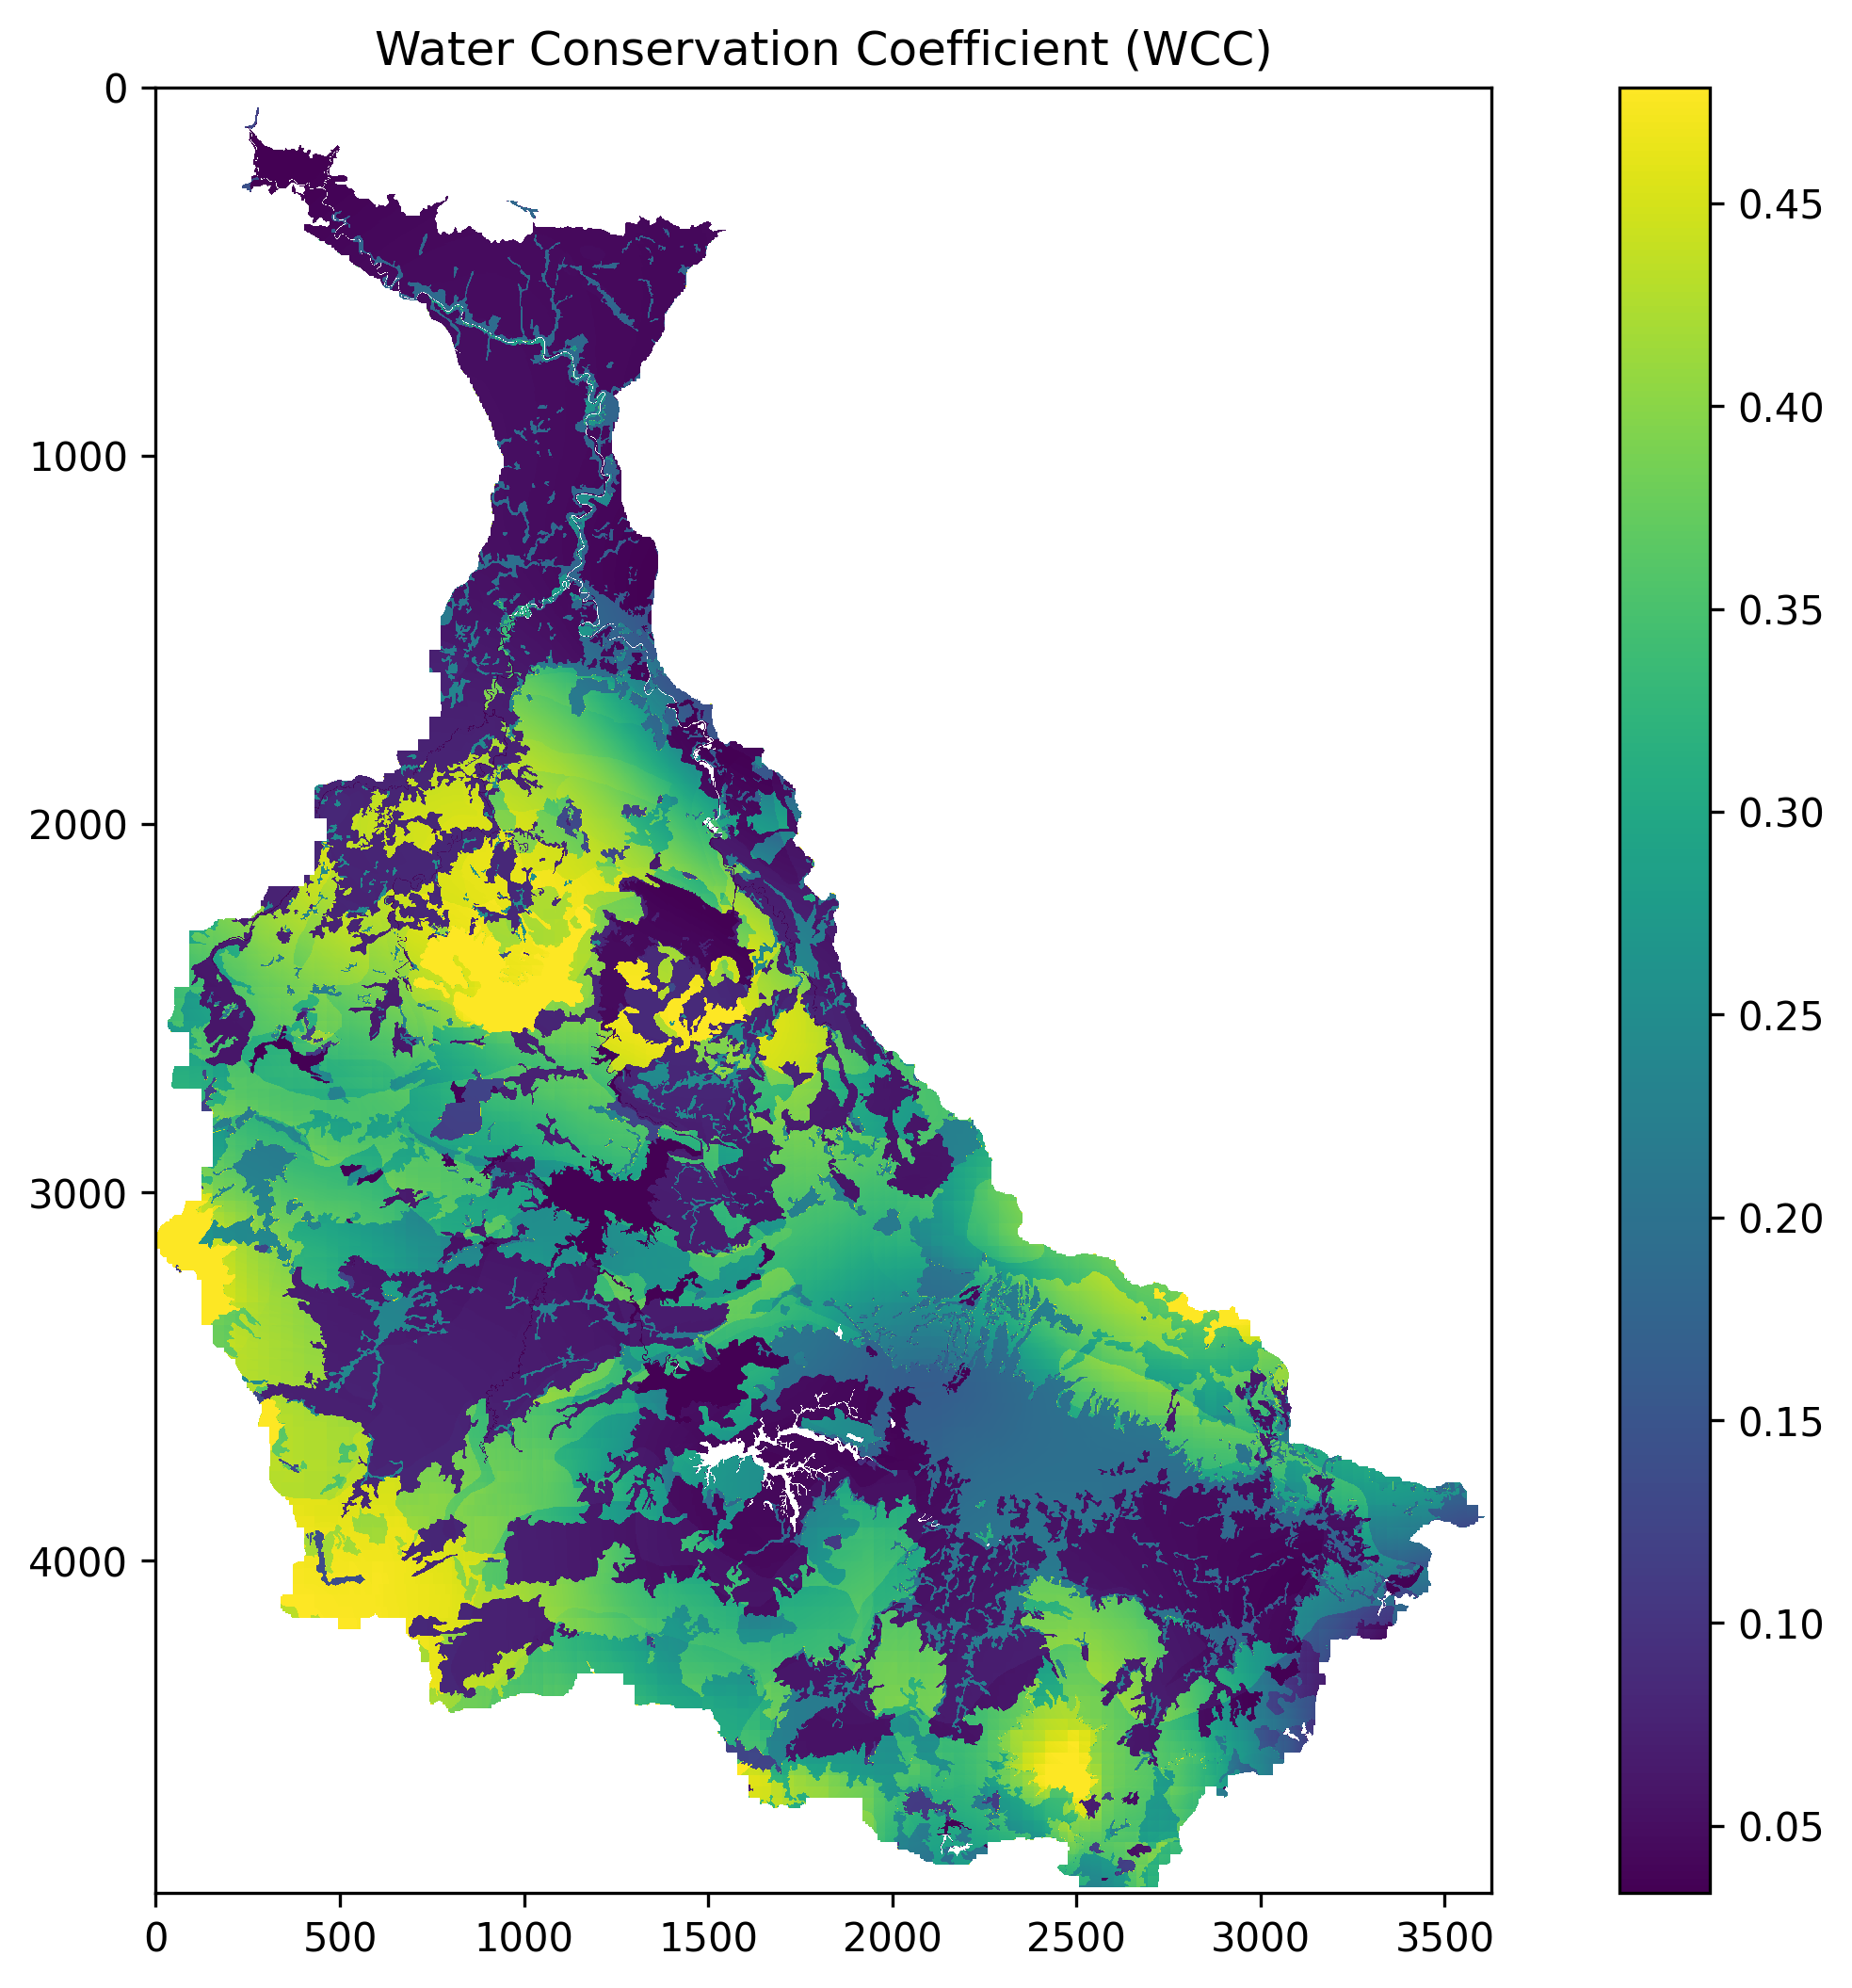

In [13]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def calculate_wcc(retention_path, precipitation_path, output_path):
    """
    Calculate the Water Conservation Coefficient (WCC) from retention and precipitation rasters.
    
    Parameters:
    - retention_path: Path to the water retention raster file.
    - precipitation_path: Path to the precipitation raster file.
    - output_path: Path for the output WCC raster file.
    """
    # Open the water retention raster
    with rasterio.open(retention_path) as retention_src:
        retention = retention_src.read(1, masked=True)  # Read with masking to handle no-data values
        
        # Open the precipitation raster
        with rasterio.open(precipitation_path) as precip_src:
            precip = precip_src.read(1, masked=True)  # Read with masking to handle no-data values
            
            # Ensure both rasters have the same shape
            assert retention.shape == precip.shape, "Retention and precipitation rasters must have the same dimensions"
            
            # Calculate WCC, handling division by zero or no-data values
            with np.errstate(divide='ignore', invalid='ignore'):
                wcc = np.where((precip.data > 0) & (~retention.mask) & (~precip.mask),
                               retention.data / precip.data, -9999)
                wcc = np.where((wcc >= 0) & (wcc <= 1), wcc, -9999)  # Keep only valid WCC values
                
                # Copy the metadata from the retention raster and update data type for WCC
                meta = retention_src.meta.copy()
                meta.update(dtype=rasterio.float32, nodata=-9999)
                
                # Write the WCC raster
                with rasterio.open(output_path, 'w', **meta) as out_raster:
                    out_raster.write(wcc.astype(rasterio.float32), 1)
    
    print(f"WCC calculation completed. Output saved to: {output_path}")
    return wcc

def plot_raster(raster_array, raster_name, output_folder):
    """Plots and saves a raster as an individual PNG (A4 Landscape, 300 DPI)."""
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

    # Convert -9999 (no-data) and 0 values to NaN for proper visualization
    plot_array = np.where((raster_array == -9999) | (raster_array == 0), np.nan, raster_array)

    # Compute color limits using percentiles to avoid extreme values
    vmin, vmax = np.percentile(plot_array[~np.isnan(plot_array)], [2, 98])

    # Create colormap and set NaN values to white
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    fig, ax = plt.subplots(figsize=(11.7, 8.3), dpi=300)  # A4 landscape size
    im = ax.imshow(plot_array, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(raster_name)
    plt.colorbar(im, ax=ax, fraction=0.05)

    # Save figure as PNG
    output_png_path = os.path.join(output_folder, f"{raster_name}.png")
    plt.savefig(output_png_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot: {output_png_path}")

    # Show the plot
    plt.show()
    plt.close(fig)  # Close the figure to free memory

# Define paths to input and output files
retention_path = './output/konservasi_air2020_v3.tif'
precipitation_path = 'inputresampling/precip_v3.tif'
output_wcc_path = './output/wcc_2020_v3.tif'
output_png_folder = './outputpng'

# Calculate WCC and plot
wcc_raster = calculate_wcc(retention_path, precipitation_path, output_wcc_path)
plot_raster(wcc_raster, "Water Conservation Coefficient (WCC)", output_png_folder)
